In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import train_test_split

2024-04-24 15:42:15.036872: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 15:42:15.036962: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 15:42:15.160806: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df=pd.read_csv("/kaggle/input/luna-data/dataset.csv")

In [3]:
df

,file,class
0,/kaggle/working/npy_files/1.3.6.1.4.1.14519.5....,1
1,/kaggle/working/npy_files/1.3.6.1.4.1.14519.5....,1
2,/kaggle/working/npy_files/1.3.6.1.4.1.14519.5....,1
3,/kaggle/working/npy_files/1.3.6.1.4.1.14519.5....,1
4,/kaggle/working/npy_files/1.3.6.1.4.1.14519.5....,1
...,...,...
1072,/kaggle/working/npy_files/1.3.6.1.4.1.14519.5....,0
1073,/kaggle/working/npy_files/1.3.6.1.4.1.14519.5....,0
1074,/kaggle/working/npy_files/1.3.6.1.4.1.14519.5....,0
1075,/kaggle/working/npy_files/1.3.6.1.4.1.14519.5....,0


In [4]:
base_path = '/kaggle/input/luna-data/npy_files/'
df['file'] = df['file'].apply(lambda x: base_path + x.split('/')[-1])
X = []  
y = []  
for _, row in df.iterrows():
    volume = np.load(row['file'])
    middle_slice = volume[volume.shape[0] // 2]
    X.append(middle_slice)
    y.append(row['class'])

In [5]:
from tensorflow.keras.utils import to_categorical
X = np.array(X).reshape(-1, middle_slice.shape[0], middle_slice.shape[1], 1)  # Reshape for CNN input
y = to_categorical(y)  

In [6]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

In [7]:
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [8]:
def build_model(input_shape, optimizer='adam', lr=0.001, neurons=128):
    if optimizer == 'adam':
        opt = Adam(learning_rate=lr)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=lr)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=lr)
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(neurons, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
learning_rates = [0.1, 0.01, 0.001, 0.0001]
lr_accuracies = []
for lr in learning_rates:
    model = build_model((X_train.shape[1], X_train.shape[2], 1), 'adam', lr)
    history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), verbose=0)
    lr_accuracies.append(history.history['val_accuracy'][-1])
optimizer_names = ['adam', 'sgd', 'rmsprop']
opt_accuracies = []
for opt_name in optimizer_names:
    model = build_model((X_train.shape[1], X_train.shape[2], 1), opt_name, 0.001)
    history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), verbose=0)
    opt_accuracies.append(history.history['val_accuracy'][-1])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
I0000 00:00:1713973371.457122      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713973371.475810      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713973374.564067      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713973375.117036      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713973380.749634      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713973382.902053      86 graph_launch.c

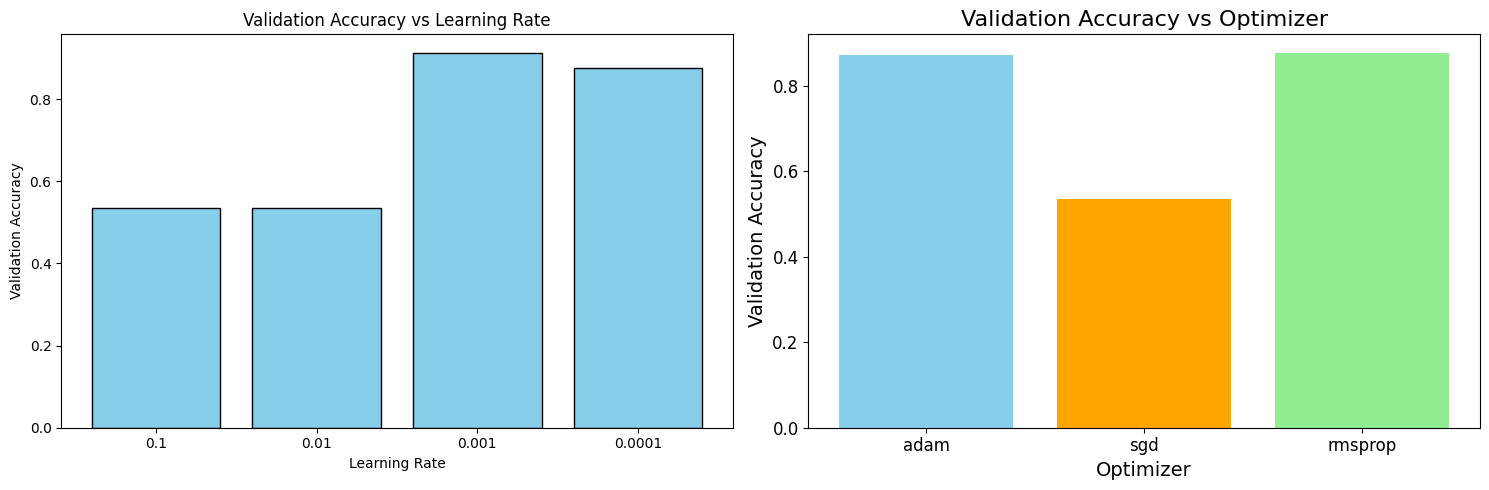

In [15]:
colors = ['skyblue', 'orange', 'lightgreen', 'orchid']
plt.figure(figsize=(15, 5))
str_learning_rates = [str(lr) for lr in learning_rates]
plt.subplot(1, 2, 1)
plt.bar(str_learning_rates, lr_accuracies, color='skyblue', edgecolor='black')
plt.title('Validation Accuracy vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
# Manually set the x-ticks to match the learning rates
plt.xticks(ticks=np.arange(len(str_learning_rates)), labels=str_learning_rates)
plt.subplot(1, 2, 2)
barlist_opt = plt.bar(optimizer_names, opt_accuracies, color=colors)
plt.title('Validation Accuracy vs Optimizer', fontsize=16)
plt.xlabel('Optimizer', fontsize=14)
plt.ylabel('Validation Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [10]:
from tensorflow.keras.utils import to_categorical
X = np.array(X).reshape(-1, middle_slice.shape[0], middle_slice.shape[1], 1)  # Reshape for CNN input
y = to_categorical(y)  

In [11]:
def build_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),  # Adding dropout for regularization
        Dense(2, activation='softmax')
    ])
    return model
batch_sizes = [2, 32, 64, 96, 128, 256]
accuracies = []
for batch_size in batch_sizes:
    model = build_model((X_train.shape[1], X_train.shape[2], 1))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    data_gen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    history = model.fit(
        data_gen.flow(X_train, y_train, batch_size=batch_size),
        epochs=30,  
        validation_data=(X_val, y_val),
        verbose=0  
    )
    accuracies.append(history.history['val_accuracy'][-1])

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1713973430.065329      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713973463.414956      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713973465.839435      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713973466.293423      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713973487.099437      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W00

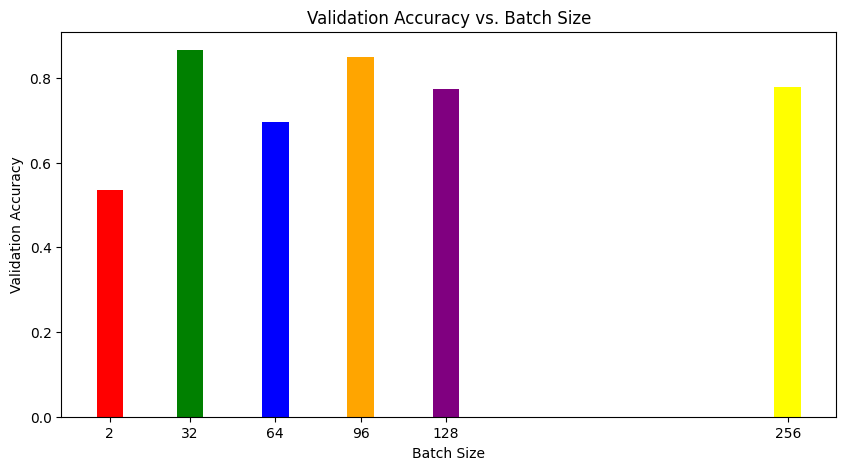

In [12]:
colors = ['red', 'green', 'blue', 'orange', 'purple', 'yellow']
plt.figure(figsize=(10, 5))
plt.bar(batch_sizes, accuracies, color=colors,width=10)
plt.title('Validation Accuracy vs. Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Validation Accuracy')
plt.xticks(batch_sizes, labels=batch_sizes)
plt.grid(False)
plt.show()

Testing combination: Optimizer=adam, LR=0.001, Batch Size=32


W0000 00:00:1713973597.402549      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713973599.380624      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713973599.858291      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Testing combination: Optimizer=adam, LR=0.0001, Batch Size=64


W0000 00:00:1713973605.320369      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713973607.305812      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713973607.899798      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Testing combination: Optimizer=sgd, LR=0.01, Batch Size=32


W0000 00:00:1713973611.722050      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713973613.360917      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713973613.822580      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Testing combination: Optimizer=sgd, LR=0.001, Batch Size=128


W0000 00:00:1713973617.894385      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713973619.526225      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713973620.127881      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713973621.172059      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Testing combination: Optimizer=rmsprop, LR=0.0001, Batch Size=64


W0000 00:00:1713973625.265486      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713973627.065958      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713973627.548165      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Testing combination: Optimizer=adam, LR=0.01, Batch Size=16


W0000 00:00:1713973634.107124      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713973636.174040      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713973636.733645      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Testing combination: Optimizer=sgd, LR=0.1, Batch Size=32


W0000 00:00:1713973641.251527      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713973642.903365      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713973643.410604      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Testing combination: Optimizer=rmsprop, LR=0.01, Batch Size=16


W0000 00:00:1713973648.041428      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713973649.927461      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713973650.420343      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Testing combination: Optimizer=adam, LR=0.0001, Batch Size=96


W0000 00:00:1713973656.194151      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713973658.172726      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713973658.743769      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


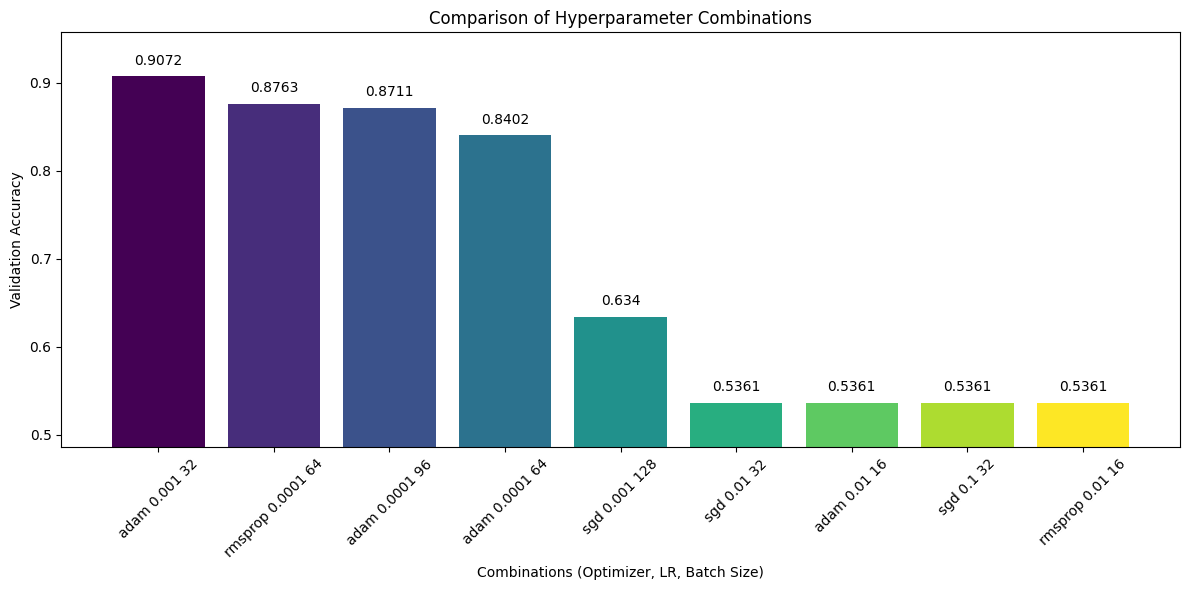

In [13]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import matplotlib.pyplot as plt
import numpy as np
optimizers = {
    'adam': Adam,
    'sgd': SGD,
    'rmsprop': RMSprop
}
combinations = [
    ('adam', 0.001, 32),
    ('adam', 0.0001, 64),
    ('sgd', 0.01, 32),
    ('sgd', 0.001, 128),
    ('rmsprop', 0.0001, 64),
    ('adam', 0.01, 16),
    ('sgd', 0.1, 32),
    ('rmsprop', 0.01, 16),
    ('adam', 0.0001, 96)
]
results = []
for optimizer_name, lr, batch_size in combinations:
    print(f"Testing combination: Optimizer={optimizer_name}, LR={lr}, Batch Size={batch_size}")
    opt = optimizers[optimizer_name](learning_rate=lr)
    
    model_testing = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    
    model_testing.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    history_testing = model_testing.fit(X_train, y_train, batch_size=batch_size, epochs=10, validation_data=(X_val, y_val), verbose=0)
    val_accuracy = history_testing.history['val_accuracy'][-1]
    results.append((optimizer_name, lr, batch_size, val_accuracy))
results.sort(key=lambda x: x[3], reverse=True)
labels = [f'{opt} {lr} {bs}' for opt, lr, bs, _ in results]
accuracies = [acc for _, _, _, acc in results]
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, accuracies, color=plt.cm.viridis(np.linspace(0, 1, len(results))))
plt.xlabel('Combinations (Optimizer, LR, Batch Size)')
plt.ylabel('Validation Accuracy')
plt.title('Comparison of Hyperparameter Combinations')
plt.xticks(rotation=45)
plt.ylim([min(accuracies) - 0.05, max(accuracies) + 0.05])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 4), ha='center', va='bottom')

plt.tight_layout()
plt.show()